# 2020 National Precinct Boundary Shapefile 10_07_2022 - updated 11_09_2022

## Background:
- We received a data request asking for a 2020 national precinct shapefile.
- VEST updated their geometries for KS and FL at the beginning of November, so RDH has modified accordingly

## Approach:
- For every state load in precinct boundary and election result shapefile originally from VEST hosted on the RDH website.
    - There are VTD estimate and precinct/county files for Kentucky and New Jersey. For this dataset, we opted to use the latter.
    - Note: Washington, D.C. is included in this file
- Select a unique identifier, column "UNIQUE_ID" for every state.
    - In instances where a unique column (besides an election result or geometry field) did not exist, a unique column was created using a combination of the two columns with the first and second closest columns to being a unique column (e.g. The dataset has 200 entries, and four non-election/geometry columns with unique counts of 175, 180, and 125. The two columns to create a unique column would be the columns with counts 180 and 175). If the UNIQUE_ID column is still not unique, a unique number (based on count/location in dataframe) is added to ensure uniqueness within the state. Additionally, the state abbreviation is appended to the front of the UNIQUE_ID column to ensure uniqueness, nationally.
- Use the pandas concat() function to join all states together with columns "STATEABRV", "UNIQUE_ID",'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', "geometry".
    - Note: Biden, Trump and Jorgensen were the three candidates with election results in every state and were included for that reason.
- Check the file
- Export the file   

## Links to Download Raw Files
- State precinct boundary and election results files available on [RDH website on every state page](https://redistrictingdatahub.org/data/download-data/), and from [VEST's Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/K7760H)
- [National BAF for 2022 Districts](https://redistrictingdatahub.org/dataset/national-block-assignment-file-for-2022-state-legislative-and-congressional-districts/)
    
## Processing Steps
- See [Github notebook](https://github.com/nonpartisan-redistricting-datahub/Processing-Requests/blob/main/National_Precinct_Bound_10_07_2022/main.ipynb)

#### Note: A full "raw-from-source" file is also available upon request. Please email info@redistrictingdatahub.org


In [1]:
import pandas as pd
import geopandas as gp
from s3_path import *
import os
import boto3
import io

state_abrvs = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


def get_unique_col(precincts,election_cols):
    elec_copy = election_cols
    unique_id = False
    election_cols.append('geometry')
    for i in list(precincts.columns):
        if len(precincts[i].unique())==len(precincts):
            if i not in elec_copy:
                unique_id = i
                #print('Unique ID is: ' ,unique_id)
                break
    if unique_id == False:
        dict_of_lens ={}
        for i in precincts.columns:
            if i not in elec_copy:
                dict_of_lens.update({i:len(precincts[i].unique())})
        max1_len=0
        max2_len=0
        max1=False
        max2=False
        for k,v in dict_of_lens.items():
            if v>max1_len:
                max2_len = max1_len
                max2 = max1
                max1_len = v
                max1 = k

            elif v>max2_len:
                max2_len = v
                max2 = k
            else:
                continue
        unique_id = str(max1)+'_'+str(max2)
        precincts[unique_id] = precincts.apply(lambda x: str(x[max1])+ ' - '+str(x[max2]),axis=1)
    if len(precincts[unique_id].unique())!=len(precincts):
        precincts['counter'] = range(len(precincts))
        precincts[unique_id] = precincts.apply(lambda x: str(x[unique_id]) + ' - ' + str(x['counter']),axis=1)
    precincts['UNIQUE_ID'] = precincts[unique_id]
    return precincts


def get_election_cols(precincts):
    election_columns = []
    for i in list(precincts.columns):
        if i.startswith('G20PRE'):
            election_columns.append(i)
    return election_columns


def concat_precincts(state_abrvs):
    gdf_len = []
    gdf_concat = pd.DataFrame()
    for state in state_abrvs:
        gdf = gp.read_file(f'zip+{path + state.lower()}_vest_20.zip')
        gdf_len.append(gdf.shape[0])
        gdf['STATEABRV'] = state
        
        gdf = get_unique_col(gdf, get_election_cols(gdf))
        gdf['UNIQUE_ID'] = gdf['STATEABRV'] + '-' + gdf['UNIQUE_ID']
        election_cols = get_election_cols(gdf)
        gdf = gdf[['STATEABRV', 'UNIQUE_ID', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'geometry']].to_crs('EPSG:4326')
        if gdf['UNIQUE_ID'].nunique()!= gdf.shape[0]:
            print(state, " unique_ids: ", gdf['UNIQUE_ID'].nunique(), " gdf shape: ", gdf.shape[0])
        gdf_concat = pd.concat([gdf_concat, gdf], sort = False)

    print('sum gdf shapes:', sum(gdf_len), '\nconcat shape:', gdf_concat.shape[0], '\nunique_id', gdf_concat['UNIQUE_ID'].nunique())
    
    return gdf_concat

In [2]:
nat_prec = concat_precincts(state_abrvs)

sum gdf shapes: 170043 
concat shape: 170043 
unique_id 170043


In [3]:
nat_prec.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
nat_prec.head()

,STATEABRV,UNIQUE_ID,G20PREDBID,G20PRERTRU,G20PRELJOR,geometry
0,AK,AK-11-075,434,761,46,"POLYGON ((-149.13365 61.61026, -149.13361 61.6..."
1,AK,AK-12-220,644,1776,57,"POLYGON ((-148.52103 61.62682, -148.52020 61.6..."
2,AK,AK-10-055,174,655,39,"POLYGON ((-149.33012 61.61391, -149.33229 61.6..."
3,AK,AK-15-300,416,695,80,"POLYGON ((-149.93126 61.25090, -149.92104 61.2..."
4,AK,AK-28-110,921,1185,39,"POLYGON ((-149.83082 61.07593, -149.83055 61.0..."


In [5]:
nat_prec['STATEABRV'].nunique()

51

In [7]:
nat_prec['geometry'] = nat_prec['geometry'].buffer(0)

In [8]:
nat_prec.head()

,STATEABRV,UNIQUE_ID,G20PREDBID,G20PRERTRU,G20PRELJOR,geometry
0,AK,AK-11-075,434,761,46,"POLYGON ((-149.13365 61.61026, -149.13361 61.6..."
1,AK,AK-12-220,644,1776,57,"POLYGON ((-148.52103 61.62682, -148.52020 61.6..."
2,AK,AK-10-055,174,655,39,"POLYGON ((-149.33012 61.61391, -149.33229 61.6..."
3,AK,AK-15-300,416,695,80,"POLYGON ((-149.93126 61.25090, -149.92104 61.2..."
4,AK,AK-28-110,921,1185,39,"POLYGON ((-149.83082 61.07593, -149.83055 61.0..."


<AxesSubplot:>

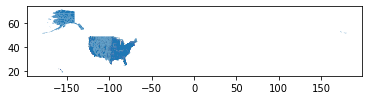

In [9]:
nat_prec.plot()

In [10]:
os.mkdir("./national_2020_prec_bounds/")
nat_prec.to_file("./national_2020_prec_bounds/national_2020_prec_bounds.shp")